In [112]:
from music21 import converter, instrument
import pickle
import matplotlib.pyplot as plt
import itertools as iter
import json
from dwave.system import DWaveSampler, EmbeddingComposite, FixedEmbeddingComposite
from dwave.samplers import SteepestDescentSolver, SimulatedAnnealingSampler
from dimod import BinaryQuadraticModel
from minorminer import find_embedding

from plotters import plotHistogram, plotSample

identifier = "haydn_opus1no1_movement1"
instruments = {"red":instrument.Flute, "green":instrument.Oboe, "blue":instrument.Bassoon}

excerpt = converter.parse(f"../Pickles/{identifier}.musicxml")
phrases = pickle.load(open(f"../Pickles/{identifier}_phrases.pkl", "rb"))
G = pickle.load(open(f"../Pickles/{identifier}_graph.pkl", "rb"))

bqm = BinaryQuadraticModel.from_serializable(json.load(open("../Pickles/bqm.json", "r")))
embedding = json.load(open(f"../Pickles/{identifier}_embedding.json"))

In [77]:
bqm = BinaryQuadraticModel(vartype="BINARY")
allPhrases = [phrase for part in phrases for phrase in part]

print(max([p.entropy for p in allPhrases]))

# Add all vertices for each colour
bqm.add_variables_from([(f"{phrase.id}_{i}", 0)for phrase in allPhrases for i in instruments.keys()])

for phrase in allPhrases:
    # Each vertex coloured at most once
    bqm.add_linear_inequality_constraint([(f"{phrase.id}_{i}", 1) for i in instruments.keys()], ub=1, lagrange_multiplier=(1,1), penalization_method="unbalanced", label="One colour per vertex")
    # Maximise vertex weighting
    bqm.add_linear_from([(f"{phrase.id}_{i}", -phrase.entropy) for i in instruments.keys()])

for u, v, d in G.edges.data():
    pass
    # Adjacent vertices have different colours
    bqm.add_quadratic_from([(f"{u}_{i}", f"{v}_{i}", 10) for i in instruments.keys()]) # Maximum node weight is ~3.946...
    # Maximise edge weighting
    bqm.add_quadratic_from([(f"{u}_{i}", f"{v}_{j}", -d["weight"]) for i,j in iter.product(instruments.keys(), repeat=2)])



3.9377202638687443


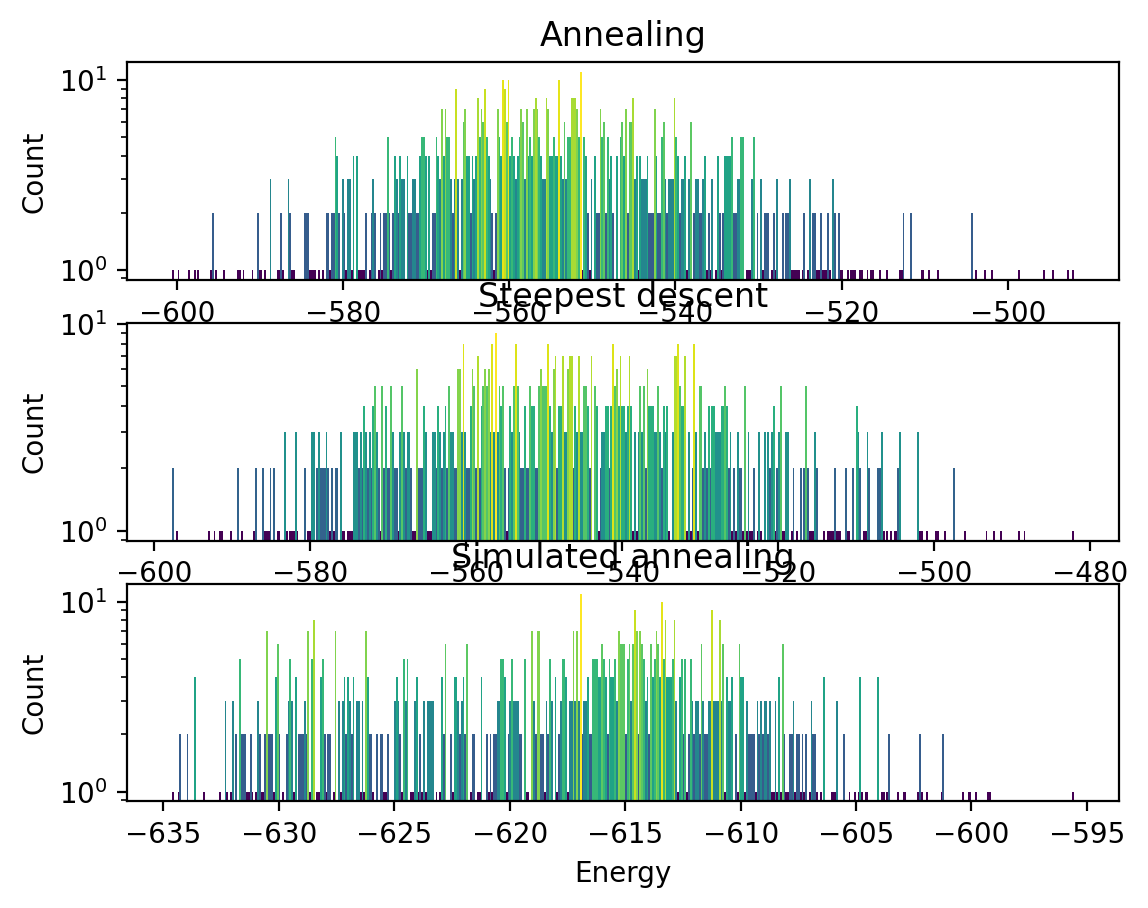

In [92]:
reads = 1000

sampler = FixedEmbeddingComposite(DWaveSampler(), embedding)
results = sampler.sample(bqm, num_reads=reads, label=f"Haydn_{reads}").to_pandas_dataframe(True)

sd = SteepestDescentSolver().sample(bqm, num_reads=reads).to_pandas_dataframe(True)
sa = SimulatedAnnealingSampler().sample(bqm, num_reads=reads).to_pandas_dataframe(True)
#sa = SimulatedAnnealingSampler().sample(bqm, num_reads=1000).to_pandas_dataframe(True)
#random = RandomSampler().sample(bqm, num_reads=1000).to_pandas_dataframe(True)

plt.subplot(3, 1, 1)
plt.title("Annealing")
plotHistogram(results)
plt.subplot(3, 1, 2)
plt.title("Steepest descent")
plotHistogram(sd)
plt.subplot(3, 1, 3)
plt.title("Simulated annealing")
plotHistogram(sa)

plt.show()

In [ ]:
# Saving to json
with open(f"../Pickles/{identifier}_bqm.json", "w") as f: 
    json.dump(bqm.to_serializable(), f)
    

In [ ]:
# Both correctly maximise total node weight (-212.02...)
# Both maximise node and edge weight (-1891.18...)
# Both maximise node and edge weight with adjacent vertices different colours (QA does better than SD but not SA) (~-247)
# There was a bug in edge weighting, didn't import `iter` module :(

print(results.sort_values("energy").head()[["energy", "chain_break_fraction", "num_occurrences"]])
print(sd.sort_values("energy").head()[["energy", "num_steps"]])
print(sa.sort_values("energy").head()[["energy", "num_occurrences"]])

       energy  chain_break_fraction  num_occurrences
7 -600.555953              0.002208                1
0 -599.845789              0.002208                1
1 -598.385571              0.002208                1
2 -597.912346              0.002208                1
3 -597.486339              0.002208                1
         energy  num_steps
622 -597.656224        160
290 -597.600600        161
301 -597.074081        146
670 -592.838582        161
991 -592.270240        169
         energy  num_occurrences
609 -634.622494                1
582 -634.311889                1
479 -634.305110                1
713 -634.282531                1
297 -633.990749                1


In [105]:
print(bqm.energy(results.sort_values("energy")["sample"][0]))
print(bqm.energy(sd.sort_values("energy")["sample"][0]))
print(bqm.energy(sa.sort_values("energy")["sample"][0]))

-599.845789035412
-536.4507950099434
-612.8003827063176


<Figure size 640x480 with 0 Axes>

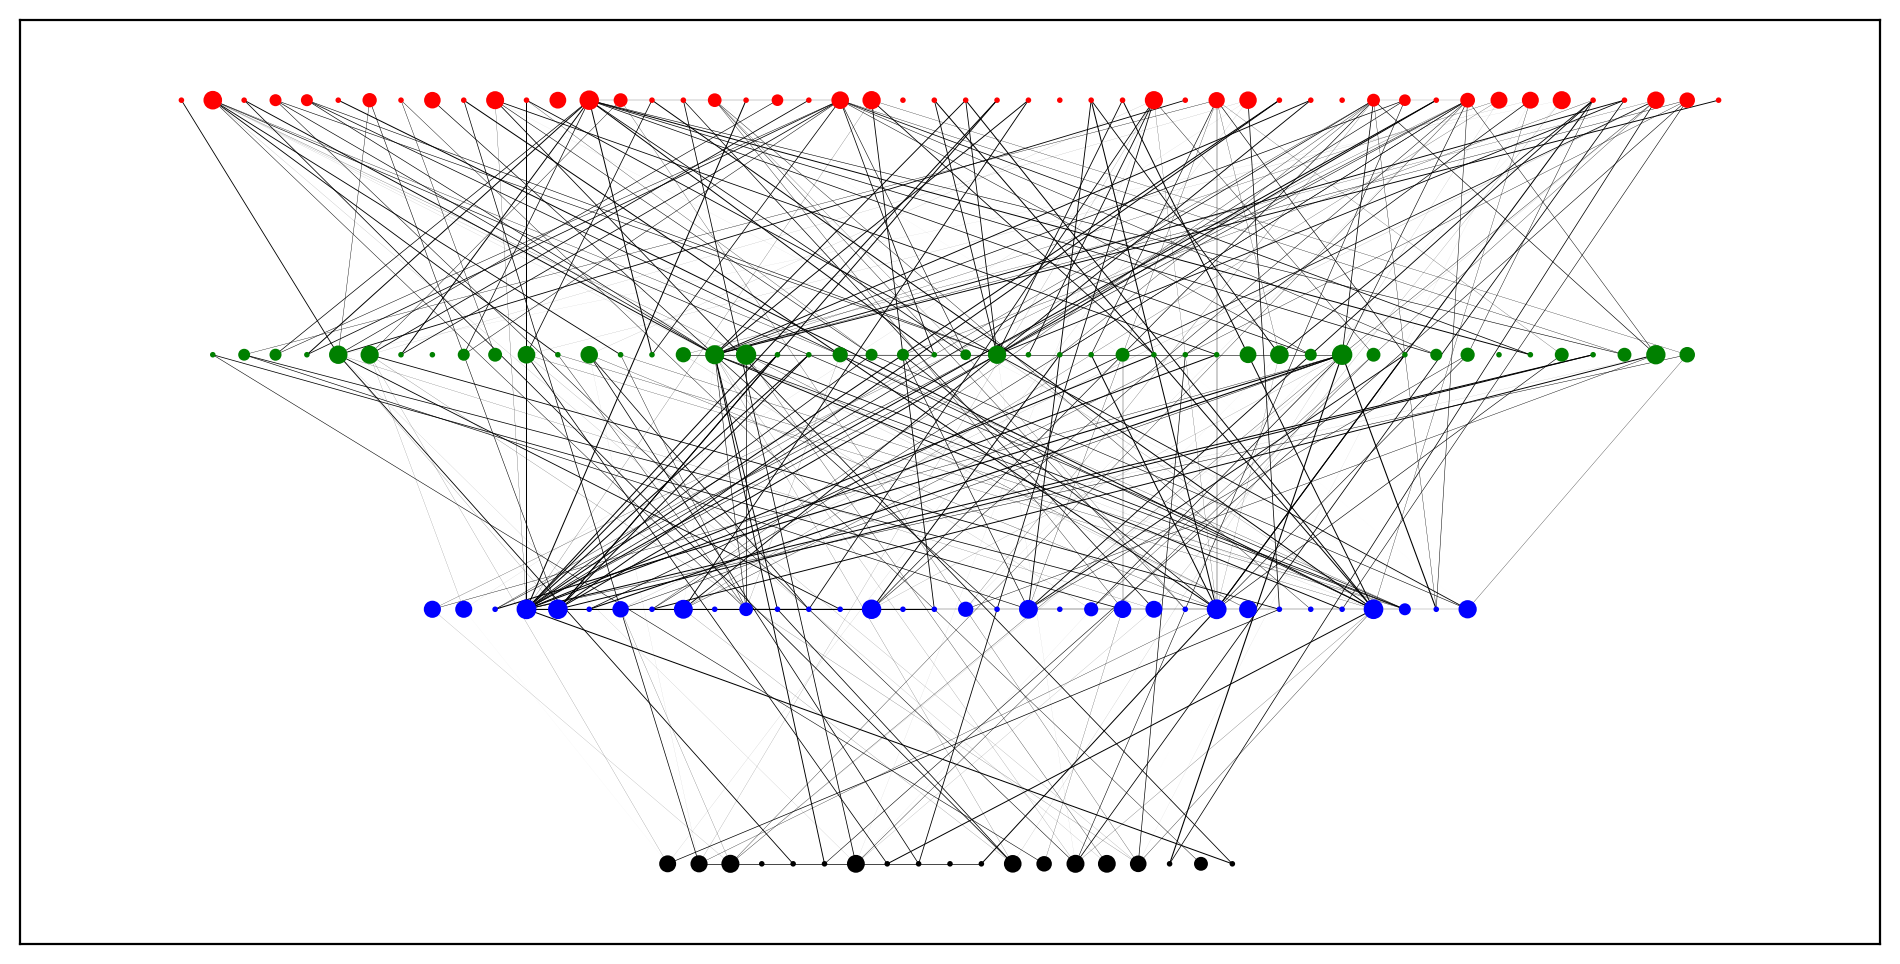

In [ ]:
# Not a good solution! Chain breaks

plotSample(results.sort_values("energy")["sample"][0], G, allPhrases)